In [4]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
%run featimp

# 1. Feature importance and selection

Feature importance is one of the important tools in Machine learning to reduce the unwanted or garbage features from our feature set. 
The goal of this report is to better understand the features in our dataset and to be able to decide on which features to select based on multiple strategies. Some of the questions we would answer include:
1. What is feature importance and why do we need it?
2. How do we judge if a feature is important or not in relative and absolute terms?
3. How do we rank the features based on feature importance?
4. What are the different strategies available to get the feature importances?
5. What is the best strategy to select the top k features?
6. How do we rank the strategies for selecting our features?
7. Is there a way we can automate our feature selection algorithm?
8. How reliable are our feature importance values?
9. How can we select features by comparing to a Null distribution of our response variable?


# 2. Direct data based feature importance
Here we try to find importances using the relation between our features with respect to the response variable and other features direclty. This direct data based approach can be used to scan the data quickly and analyze the important features at an early stage of the data science pipeline. We will use following approaches here:
1. Rank by Spearman's rank correlation coefficient
2. PCA based approach
3. Minimal-redundancy-maximal-relevance (mRMR)

I have used the California housing data (https://www.kaggle.com/camnugent/california-housing-prices) for this project which we will use the features to predict the median house value as our target variable. It contains 9 columns in total and we will predict median house value based on other 8 features in the dataset.

In [5]:
housing = pd.read_csv('housing.csv').iloc[:,:-1] #https://www.kaggle.com/camnugent/california-housing-prices
housing.dropna(inplace=True)



## 2.1  Spearman's correlation
Spearman's correlation determines the strength and direction of the monotonic relationship (by considering rank) between your two variables rather than the strength and direction of the linear relationship between the two variables (Pearson's correlation). Here generally the feature with the largest coefficient comes out to be the most important (Again similar to Pearson). This method works well for independent features, but suffers in the presence of co-dependant features since we check relevance one feature at a time. If we have features with similar relationships to the response variable they will receive the similar ranks as in the case of multi-collinearity, even though just one should be considered important. Also we use the absolute value of the importances to compare relative importance of features to make the ranking of features.

The Spearman's correlation is plotted below (Actual values) to show the imporatances of our features in our housing dataset with respect to respone variable median house value.

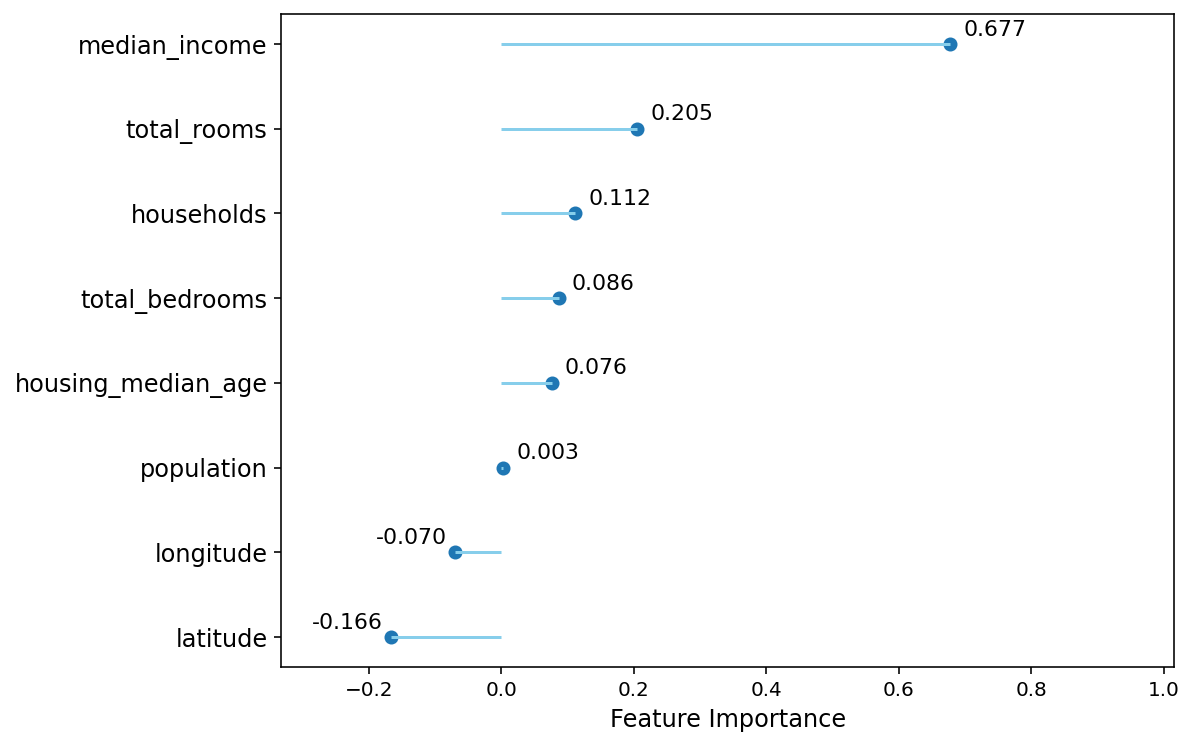

In [65]:
ls, sc = Spearman_imp(housing,'median_house_value',probs = True)
df = list_to_pd(housing,'median_house_value',ls=ls, sc = sc)

plot_feat_imp(df).show()

## 2.2 PCA

Here we get the linear components/loads associated with the first principle component which explains most of the variance of the data. The loads of the principle components are representing the feature loads since we have transformed our data in the new feature space.

This method is generally good when the first component explains the large portion of the variance.

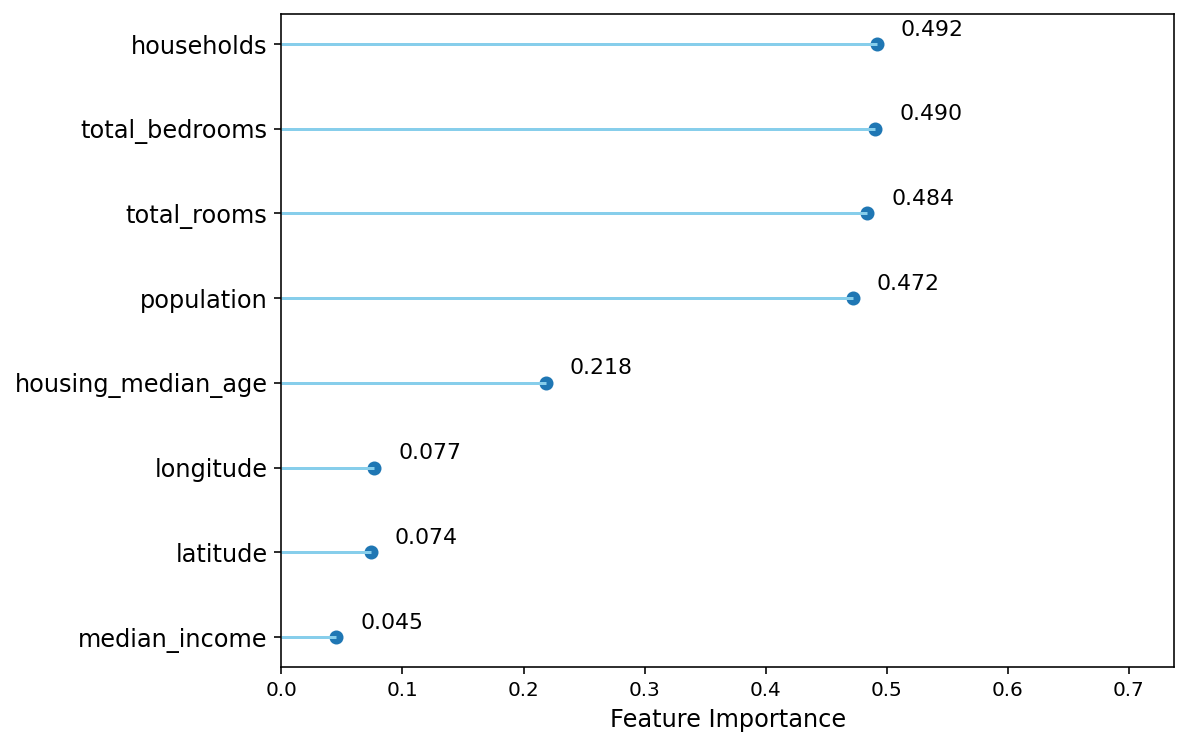

In [67]:
ls, sc = pca_imp(housing,'median_house_value',probs = True)
df = list_to_pd(housing,'median_house_value',ls=ls, sc = sc)
plot_feat_imp(df).show()

## 2.3 Minimal-Redundancy-Maximal-Relevance (MRMR)

In order to deal with codependencies, we rank features not just by relevance (correlation with the response variable) but also by low redundancy (the amount of information shared between features). This is the main motivation behind minimal-redundancy-maximal-relevance (MRMR).
Steps involve finding:

$$J_{mRMR}(x_k) = I(x_k, y) - \dfrac{1}{|S|}\sum _{x_{j}\in S}I( x_{k},x_{j})$$
𝑆 is the cardinality of the selected subset. I(x<sub>k</sub>,x<sub>j</sub>), 𝑆 is the growing set of selected features we take in each iteration, and x<sub>k</sub> is the Spearman's correlation for 𝐼(x<sub>k</sub>,x<sub>j</sub>)

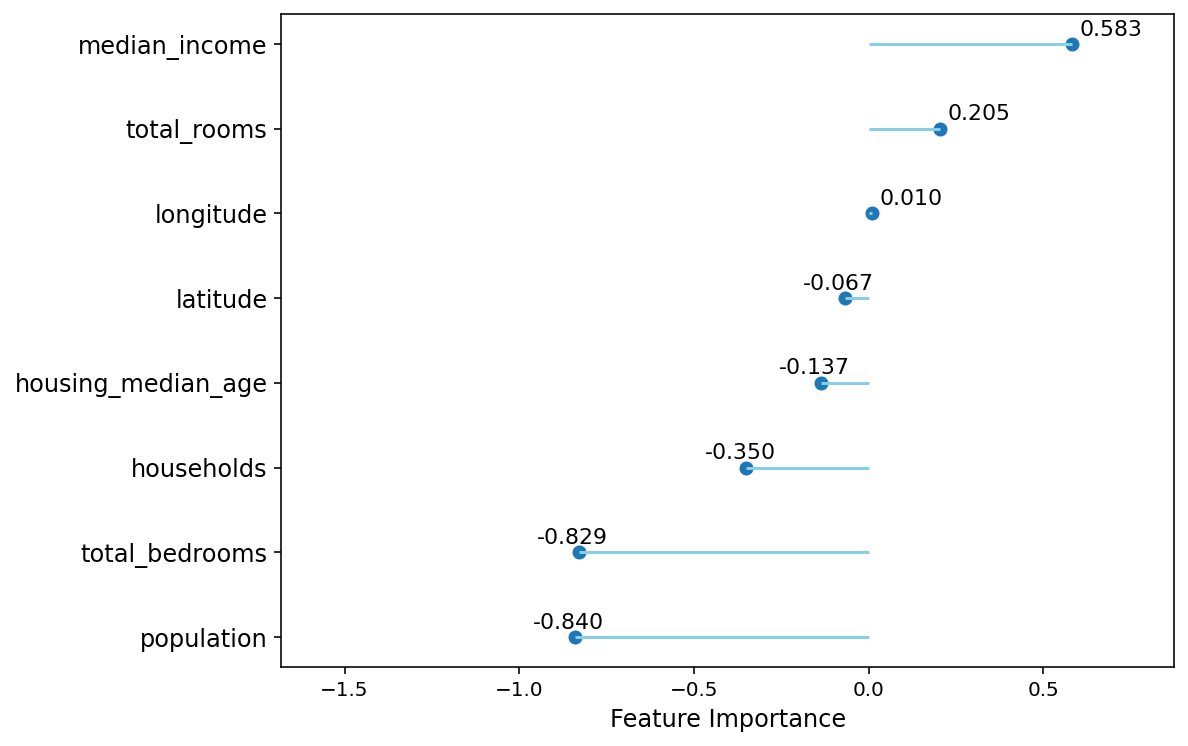

In [75]:
ls, sc = mrmr_imp(housing,'median_house_value',probs = True)
df = list_to_pd(housing,'median_house_value',ls=ls, sc = sc)
plot_feat_imp(df).show()

</br>

# 3. Model based feature importance
Model based feature importance involves fitting a model such as random forest to all the features and finding the relation between feature and the response variable. The importances obtained will be dependant on the model chosen and the accuracy of our model fit. A biased or inaccurate model will unreliable importance values. Some of the methods that we will try involve:
1. Permutation importance
2. Drop column importance
3. OLS based feature importance
4. Random forest based Gini-drop importance
</br>
</br>


## 3.1 Drop column importance

As the name suggests we drop the feature and check the drop in the validation metric or loss for the feature. This method is computationally expensive as it involves refitting the model to the respose each time we drop a feature. Here we have used MAE for the drop in loss for validation set. Following are the steps:
> 1. Compute validation metric for model trained on all features 
2. Drop column 𝑥<sub>j</sub> from training set
3. Retrain model
4. Compute validation metric set
5. Importance score is the change in metric

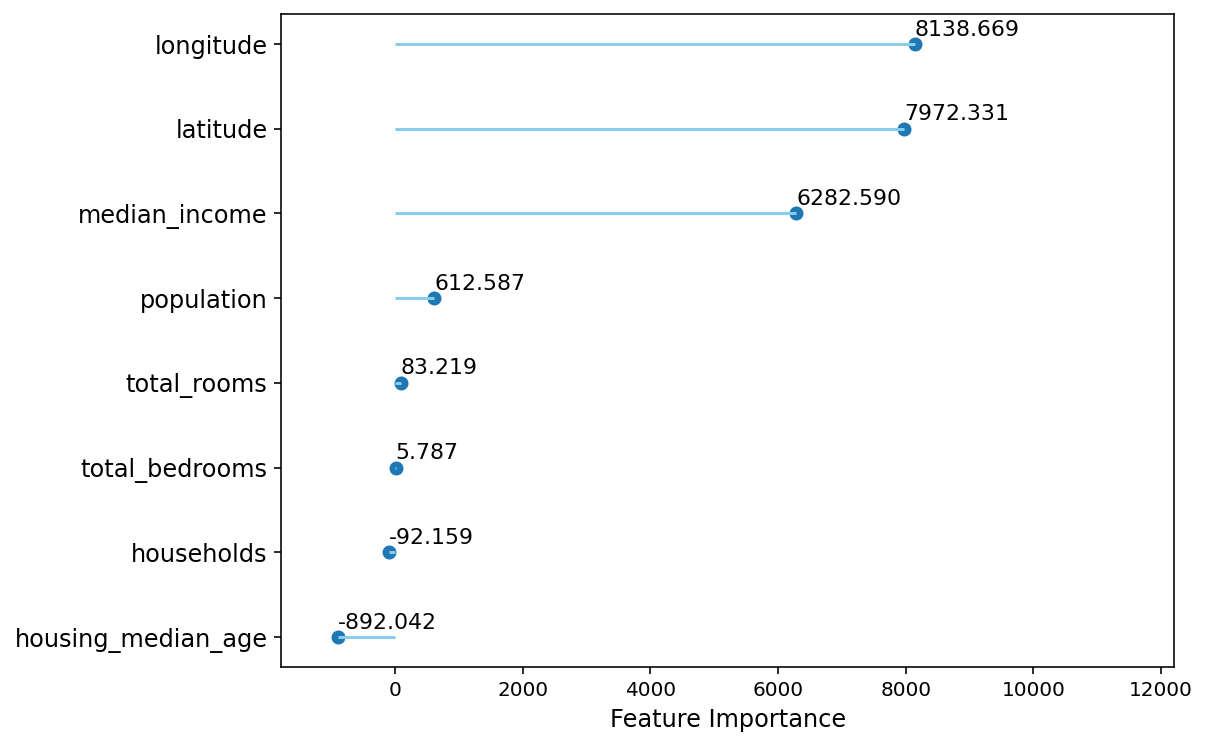

In [14]:
model = RandomForestRegressor(n_estimators=10,max_depth=10,min_samples_leaf=50)
ls, sc = dropcol_importances(model, housing, 'median_house_value')
df = list_to_pd(housing,'median_house_value',ls=ls, sc = sc)
plot_feat_imp(df).show()

## 3.2 Permutation importance

As the name suggests we permute the feature instead of dropping to break the relation between the response variable (in our case Median house price) and the selected feature. The drop or gain in the loss(or metric) on validation set is noted. Here we have used MAE as the metric. Following are the steps:
>1. Compute validation metric for model trained on all features
2. Permute column 𝑥<sub>j</sub> in validation set
3. Compute validation metric set
4. Importance score is the change in metric

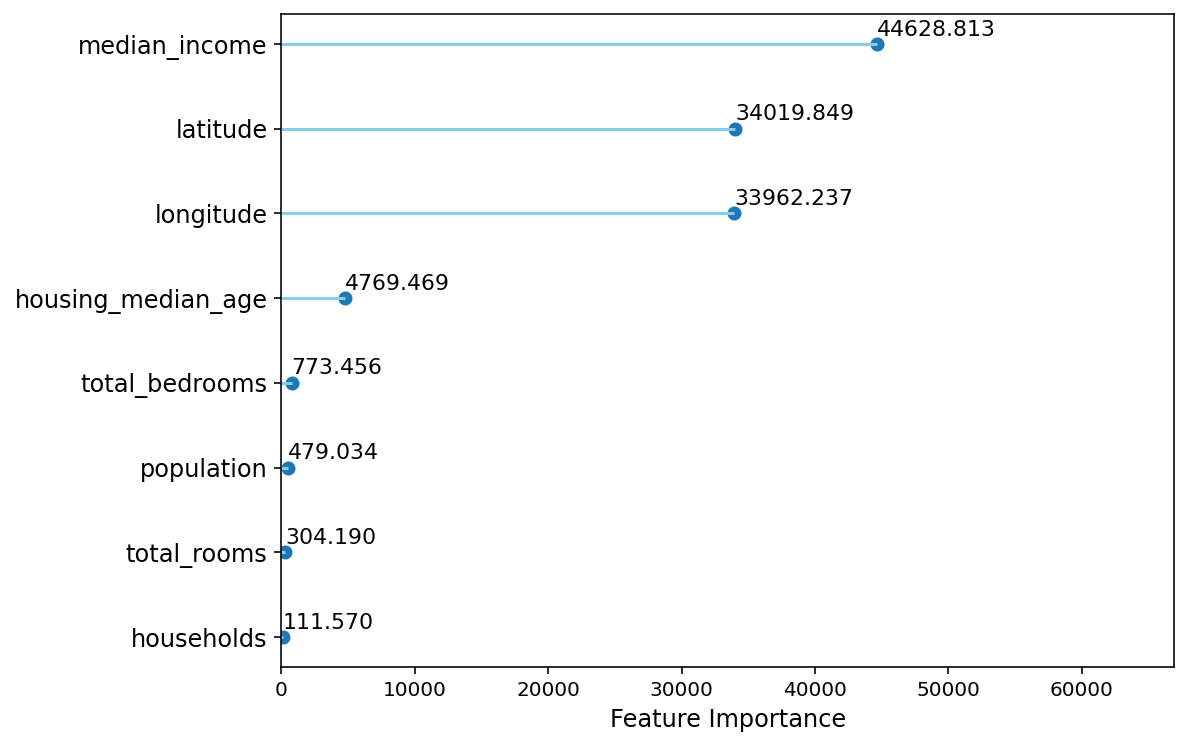

In [17]:
model = RandomForestRegressor(n_estimators=10,max_depth=10,min_samples_leaf=50)
ls, sc = permutation_importances(model, housing, 'median_house_value')
df = list_to_pd(housing,'median_house_value',ls=ls, sc = sc)
plot_feat_imp(df).show()

## 3.3 OLS based importance

Here we fit a linear equation using ordinary least square technique on the data and take the coefficient with respect to the feature as its importance. This technique is not well suited for non linear data as we are fitting a linear equation and estimating a linear relationship between response and the feature.

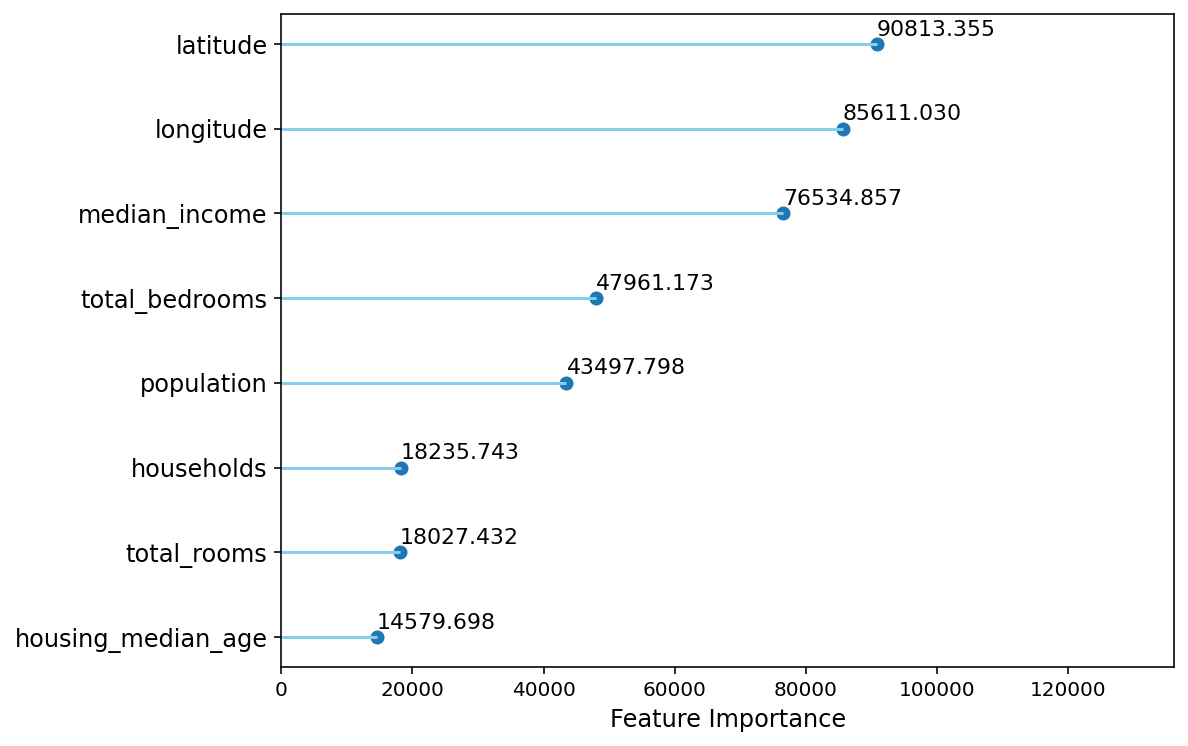

In [64]:
ls, sc = ols_imp(housing,'median_house_value',probs = True)
df = list_to_pd(housing,'median_house_value',ls=ls, sc = sc)
plot_feat_imp(df).show()

## 3.4 Random forest based Gini-drop importance
There are other types of feature importance “gini drop”. The main idea here is to track how much the loss function drops from a decision node to its children (for a given split variable). The average loss function drop for a specific 𝑥<sub>j</sub> across decision nodes for 𝑥<sub>j</sub> and across all trees gives the feature importance. Unfortunately, this gives biased feature importances as exhaustively testing every unique 𝑥<sub>j</sub> value when finding decision node splits increases likelihood of finding a 𝑥<sub>j</sub> value that, purely by chance, happens to predict 𝑦 well. That increases the likelihood that variable 𝑥! will appear more often in the trees, which leads to inflated/biased importance. Breiman: “adding up the gini decreases for each individual variable over all trees in the forest gives a fast variable importance that is often very consistent with the permutation importance measure.”

## 4. Comparing strategies

Now we will compare various feature importances obtained using the above discussed techniques. Random forest model is used to fit the model on top k = 1,..p features selected using various strategies to see how the curves for various feature imporatnce strategies vary. This comparison strategy again is model dependent. Hence we have used OLS and XGBoost to check various strategies. Using Random forest we find that OLS gives the best result since we observe the curve for MAE validaiton loss using top k features is below all other curves. 

In [84]:
func_ls = [Spearman_imp,pca_imp,ols_imp, mrmr_imp]
J = compare(housing, 'median_house_value',func_ls)

### 4.1 Comparison using random forest model

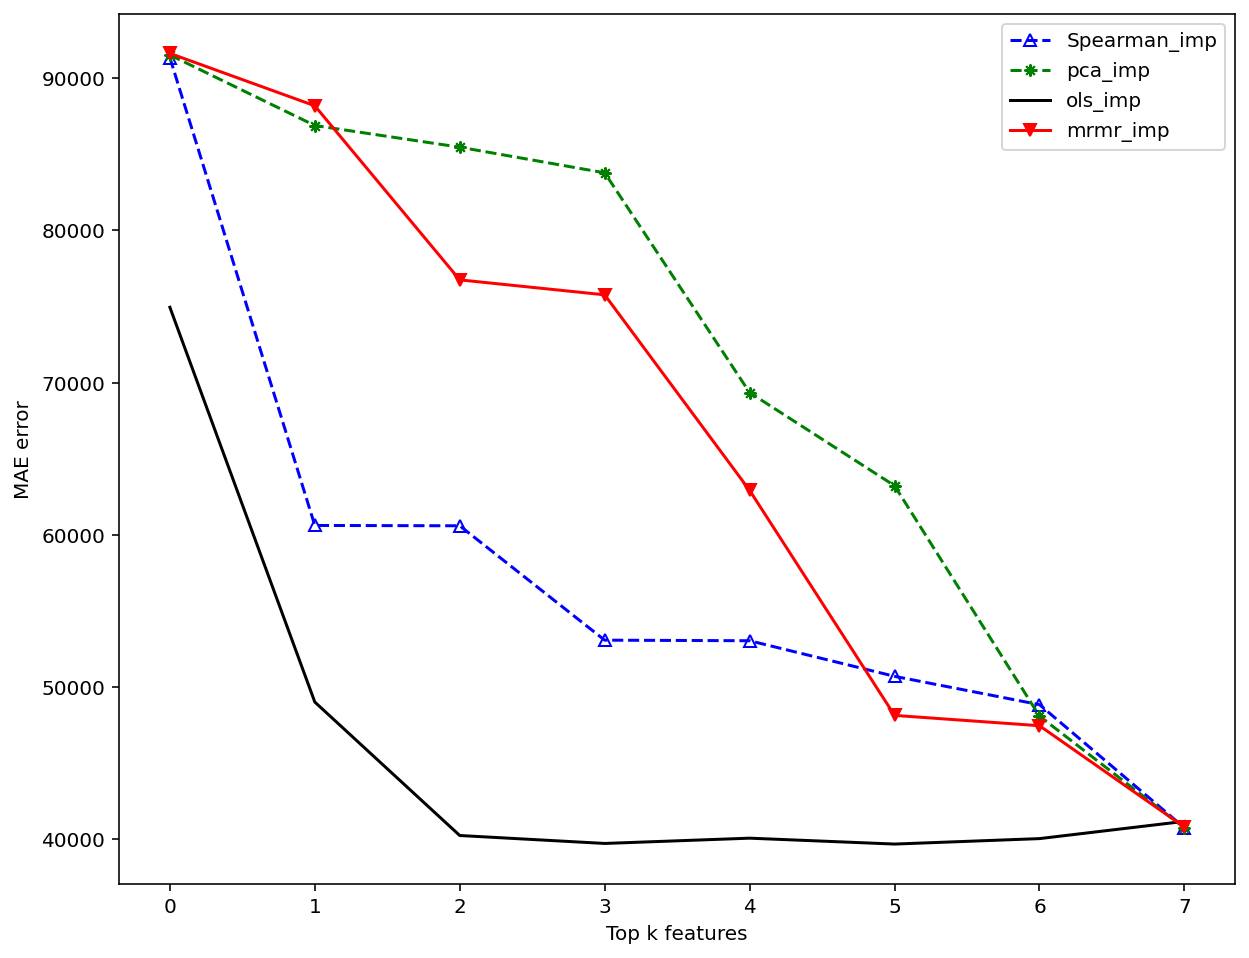

In [106]:
df_imp = RF_strategy(housing, 'median_house_value',J)
plt = plot_strategy(df_imp)
plt.show()

### 4.2 Comparison using OLS model

Here we have fit XGBoost model to compare various strategies of feature importance. Here the best strategy is not as clear as in the case with random forest. We will select top K features based on the K features we want to include in our model.

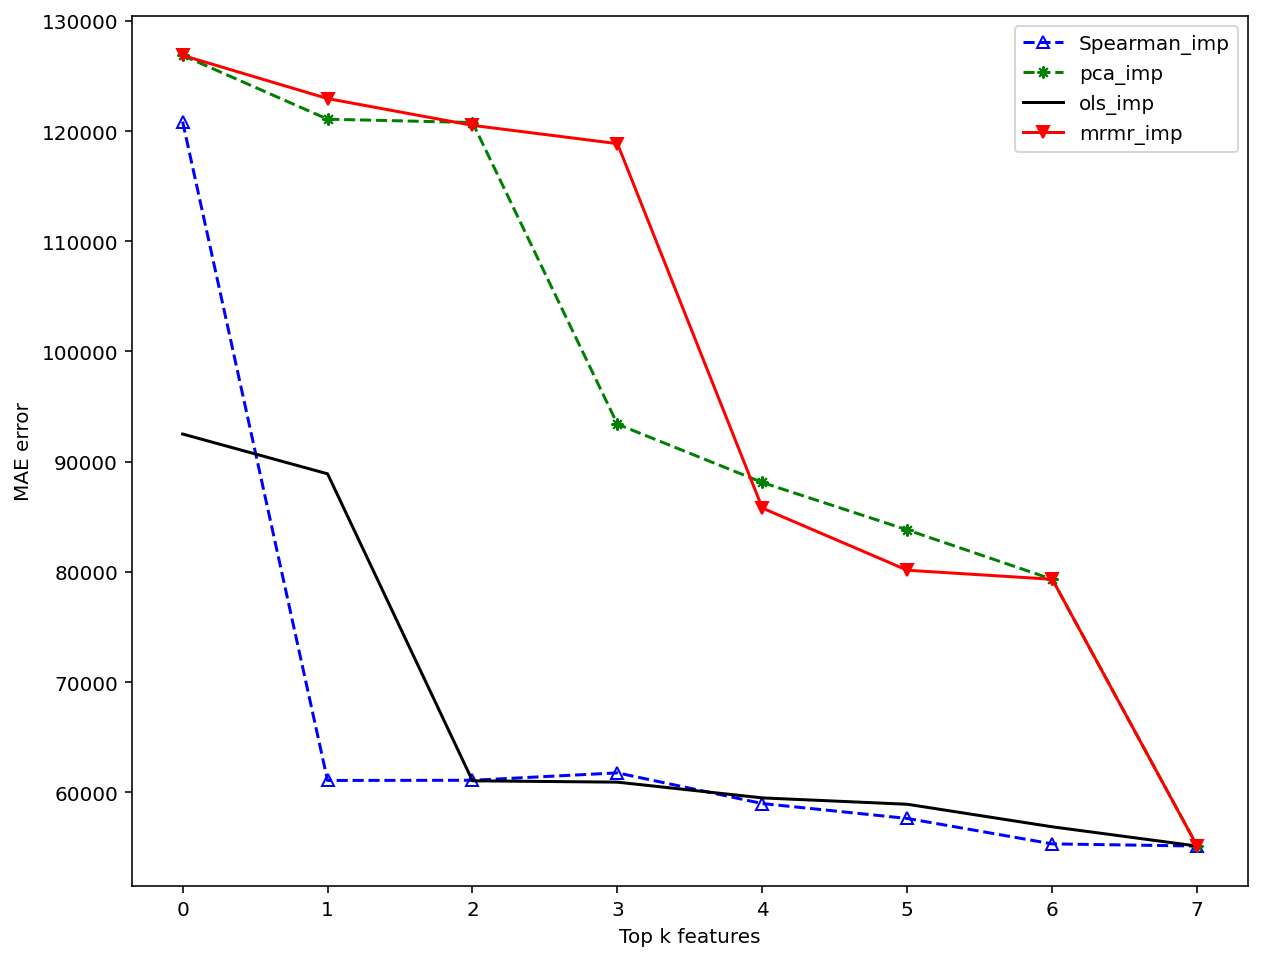

In [107]:
df_imp = OLS_strategy(housing, 'median_house_value',J)
plt = plot_strategy(df_imp)
plt.show()

### 4.3 Comparison using XGBoost model

For XGBoost again OLS feature selection is best among all the strategies for selecting top k features.

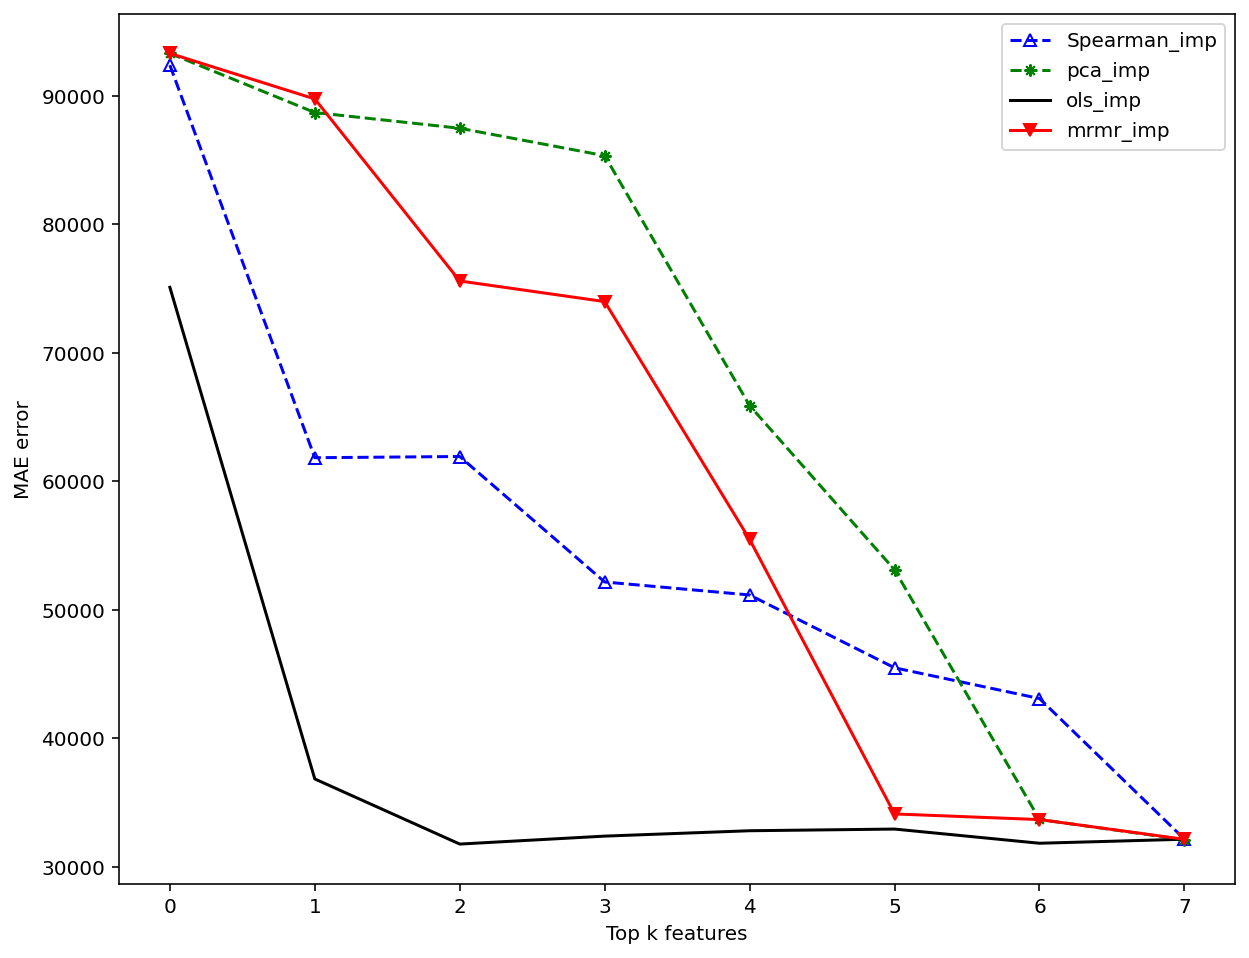

In [108]:
df_imp = xgboost_strategy(housing, 'median_house_value',J)
plt = plot_strategy(df_imp)
plt.show()

### 4.4 Comparison with Shap 

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. (Credits: https://github.com/slundberg/shap)
Below is a graph showing feature importance obtained from SHAP.

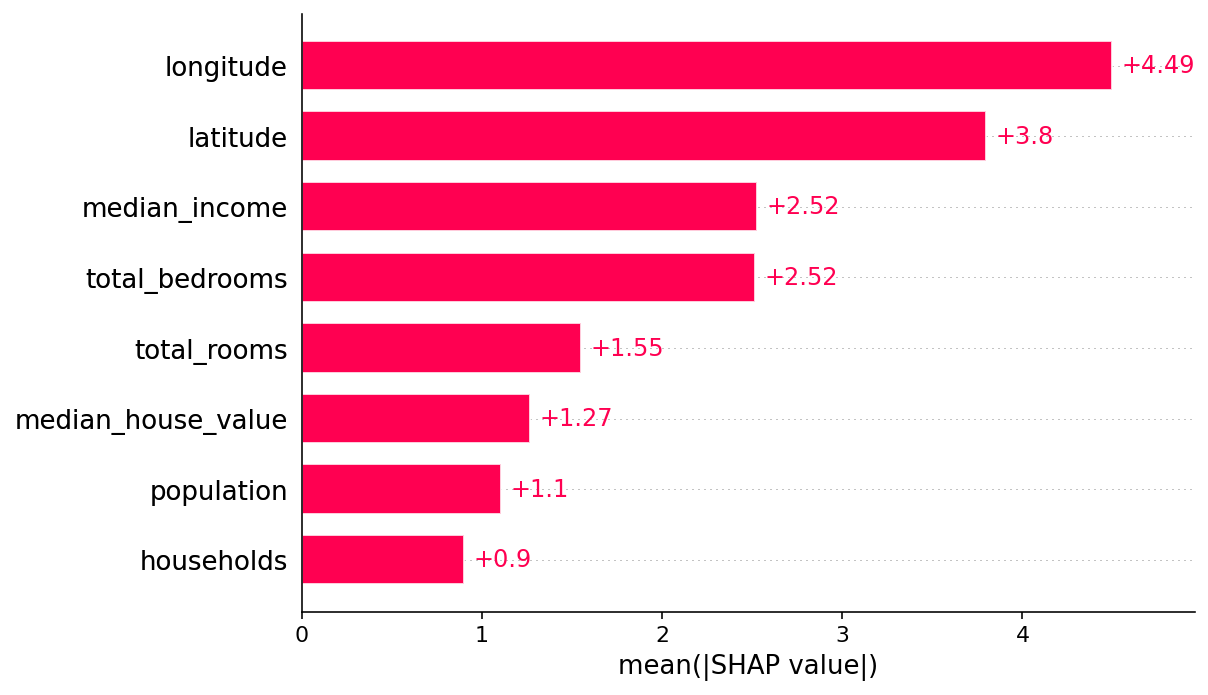

In [110]:
model = xgboost.XGBRegressor().fit(housing.loc[:,housing.columns!='housing_median_age'], housing['housing_median_age'].values)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(housing.loc[:,housing.columns!='housing_median_age'])

shap.plots.bar(shap_values)

The strategies we discussed earlier is used to comapare with SHAP using XGBoost model. SHAP gives good result on tree based model but for linear models Spearman and OLS feature improtance work best. PCA performs worst in most cases for our data chosen.

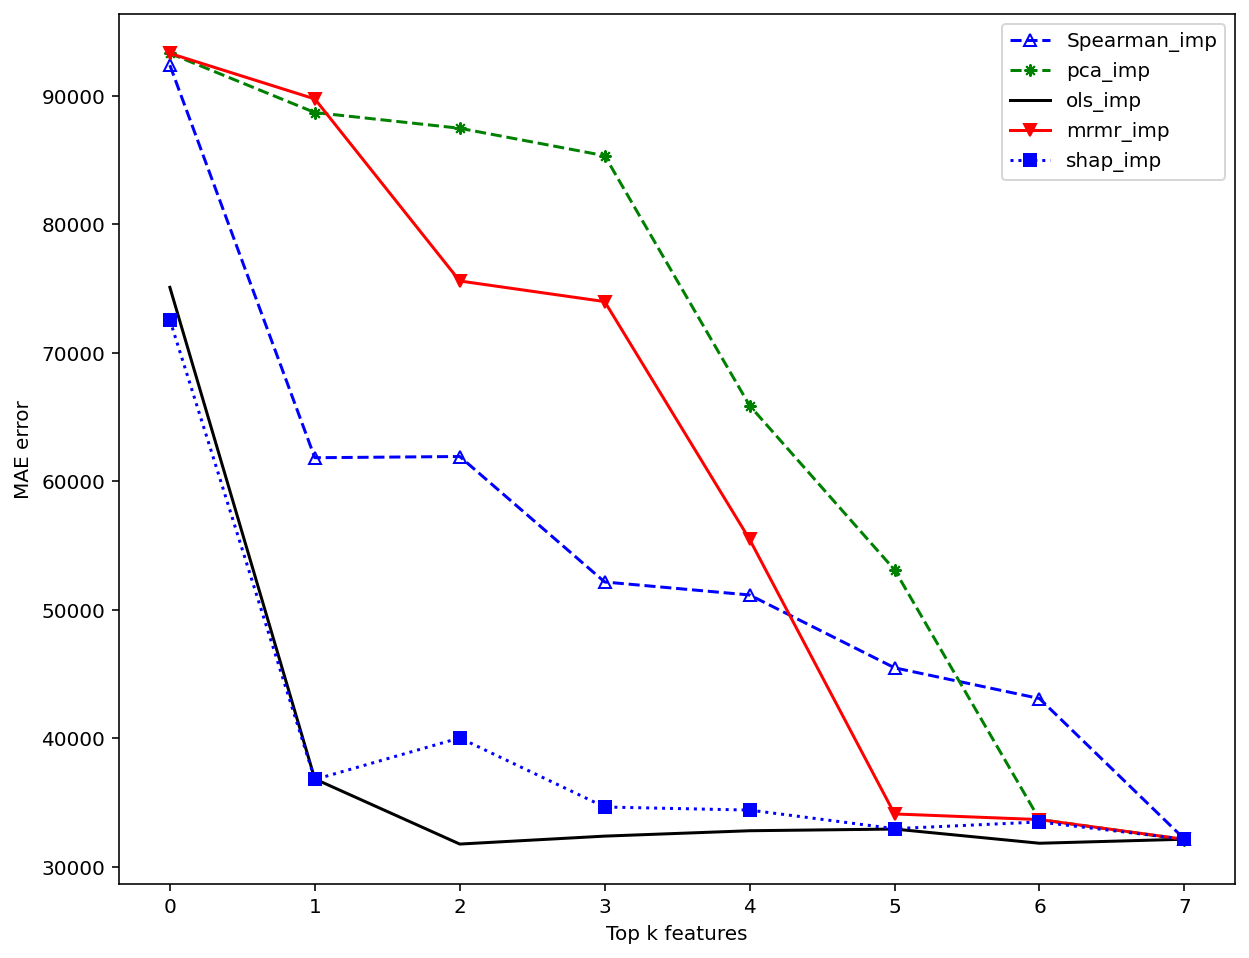

In [160]:
sc = abs(shap_values.values).sum(axis=0)/shap_values.values.shape[0]
J_shap = J.copy()
J_shap['shap'] = len(sc) - rankdata(sc)
df_imp = xgboost_strategy(housing, 'median_house_value',J_shap)
plt = plot_strategy_shap(df_imp)
plt.show()

OLS model for comparison of various feature importance strategy with SHAP

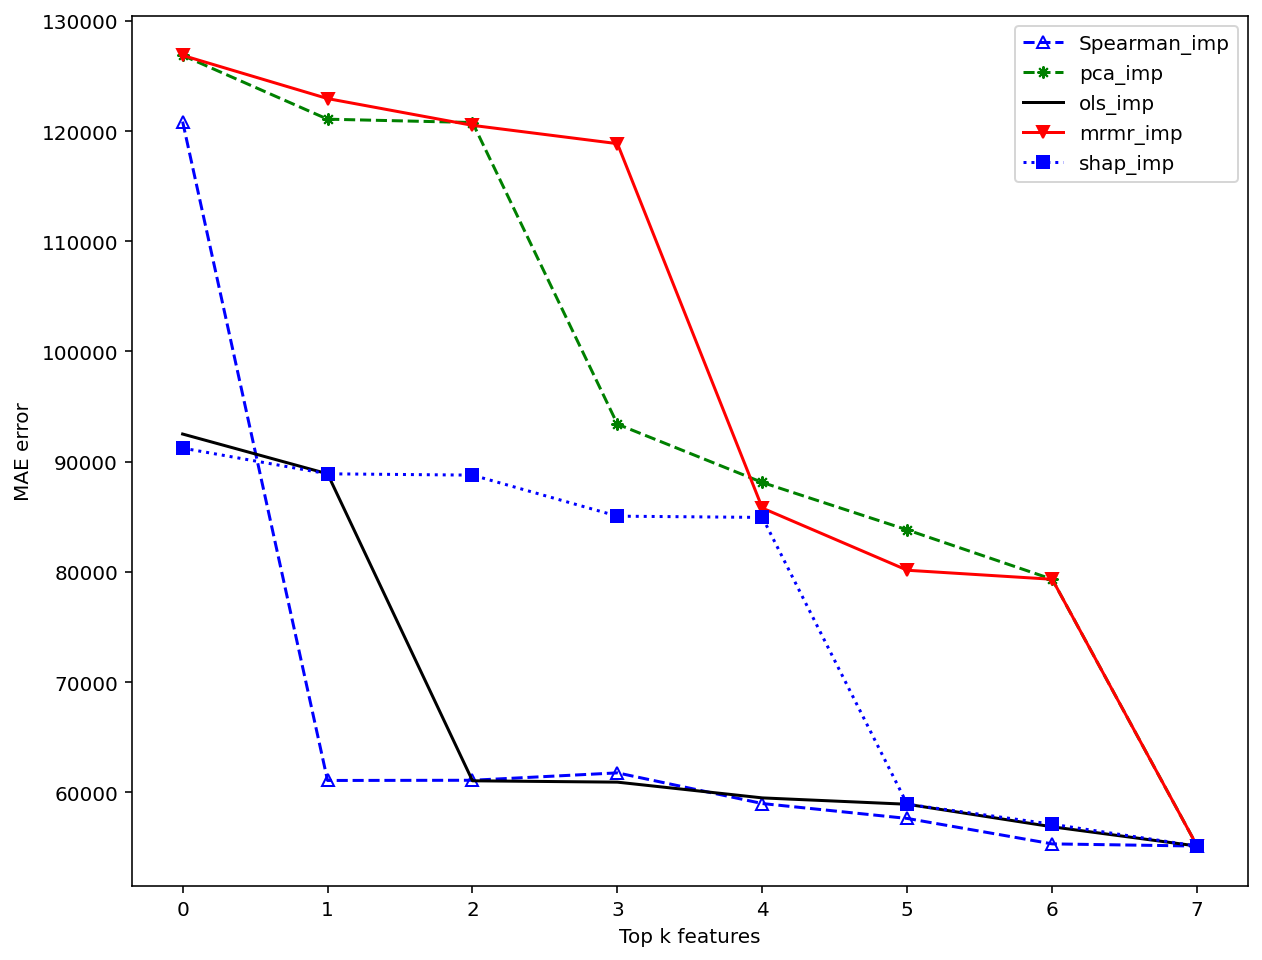

In [161]:
df_imp = OLS_strategy(housing, 'median_house_value',J_shap)
plt = plot_strategy_shap(df_imp)
plt.show()

## 5. Automatic feature selection algorithm
We will now discuss the mechanism to drop off unimportant features and keep the top k features from most important to least important. This will be an automated mmechanism to select top K features. 
We will begin by dropping the least important features and check for the deacrease in validation loss. We will keep continuing to drop the features till the validation loss/metric (recomputed after each drop of feature) starts to increase. This will be our selected top k features. 

Again this will be model dependent and the optimal top k features will be decided based on the model selected. Here we have used random forest model and we get top 3 features as important using OLS feature importance strategy. This can be combined with the earlier method to select best strategy and fully automated to get the top k features using the best strategy of feature importance for a given model. 

The below plot depicts the optimal point which is the top k features to choose based on the selected model and strategy(Random forest and OLS feature importance)

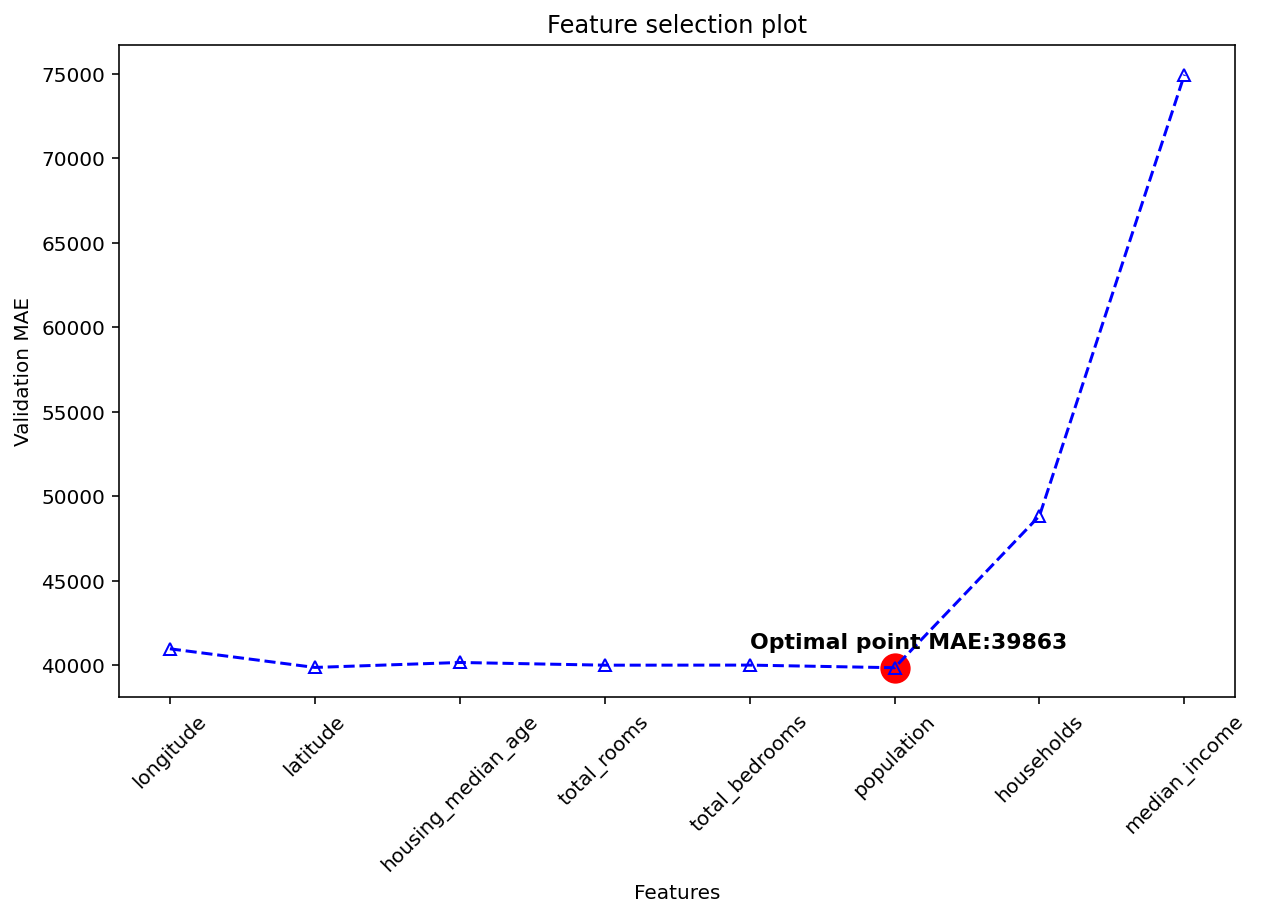

In [124]:
ls, sc = ols_imp(housing,'median_house_value',probs = True)
df = list_to_pd(housing,'median_house_value',ls=ls, sc = sc)
model = RandomForestRegressor(n_estimators=10,max_depth=10,min_samples_leaf=50)
val_mae,j = feature_select(housing, df, model, target = 'median_house_value')
df['val_mae'] = val_mae
feature_selection_plot(df,j).show()

## 6. Variance and empirical p-values for feature importances

Here we generate bootstrap samples from our data to repeat the feature importance computation. We then use this data to get the 95% confidence interval. These intervals are plotted below along with the actual values.

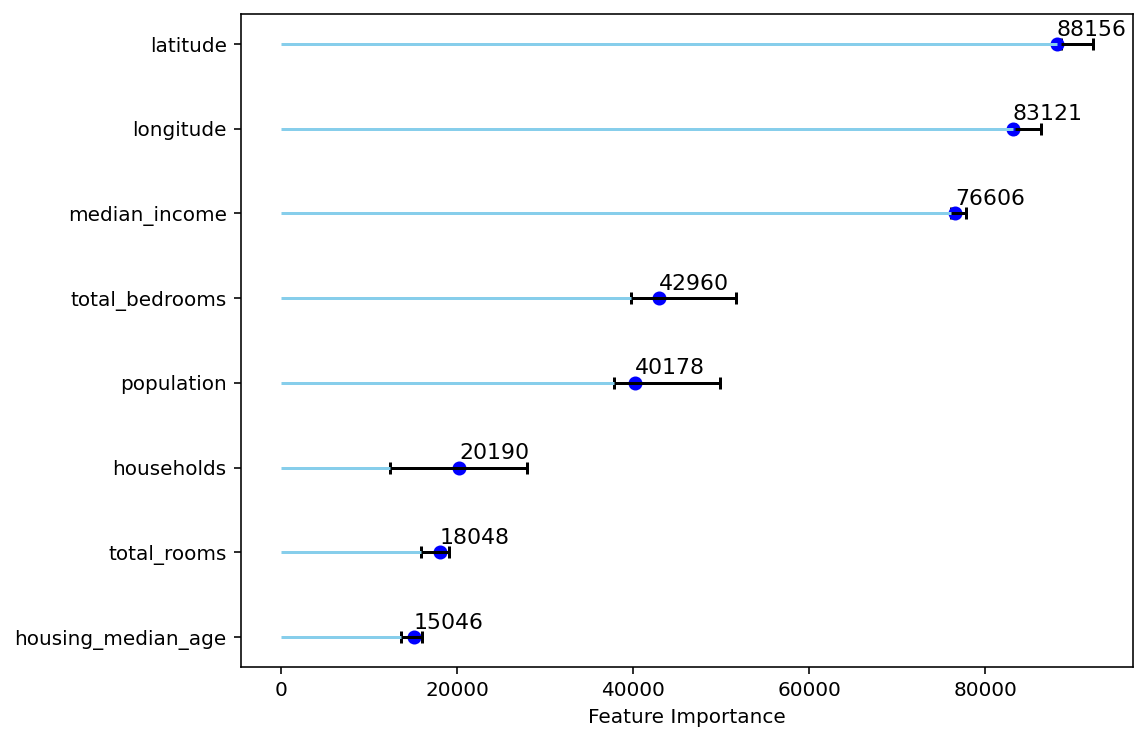

In [25]:
feature_imp_plot(df, dataset=housing).show()

Next we generate null distribution of feature importances. This is done by repeatedly shuffling the response variable to get the feature importance for each feature. Here we have used random forest regressor and permutation feature importance to plot the Null distrubtion and the actual feature importance. The p-value is defined as the fraction of times the feature importance of null distribution crosses the actual feature importance for that feature.

<module 'matplotlib.pyplot' from '/Users/vishpra/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

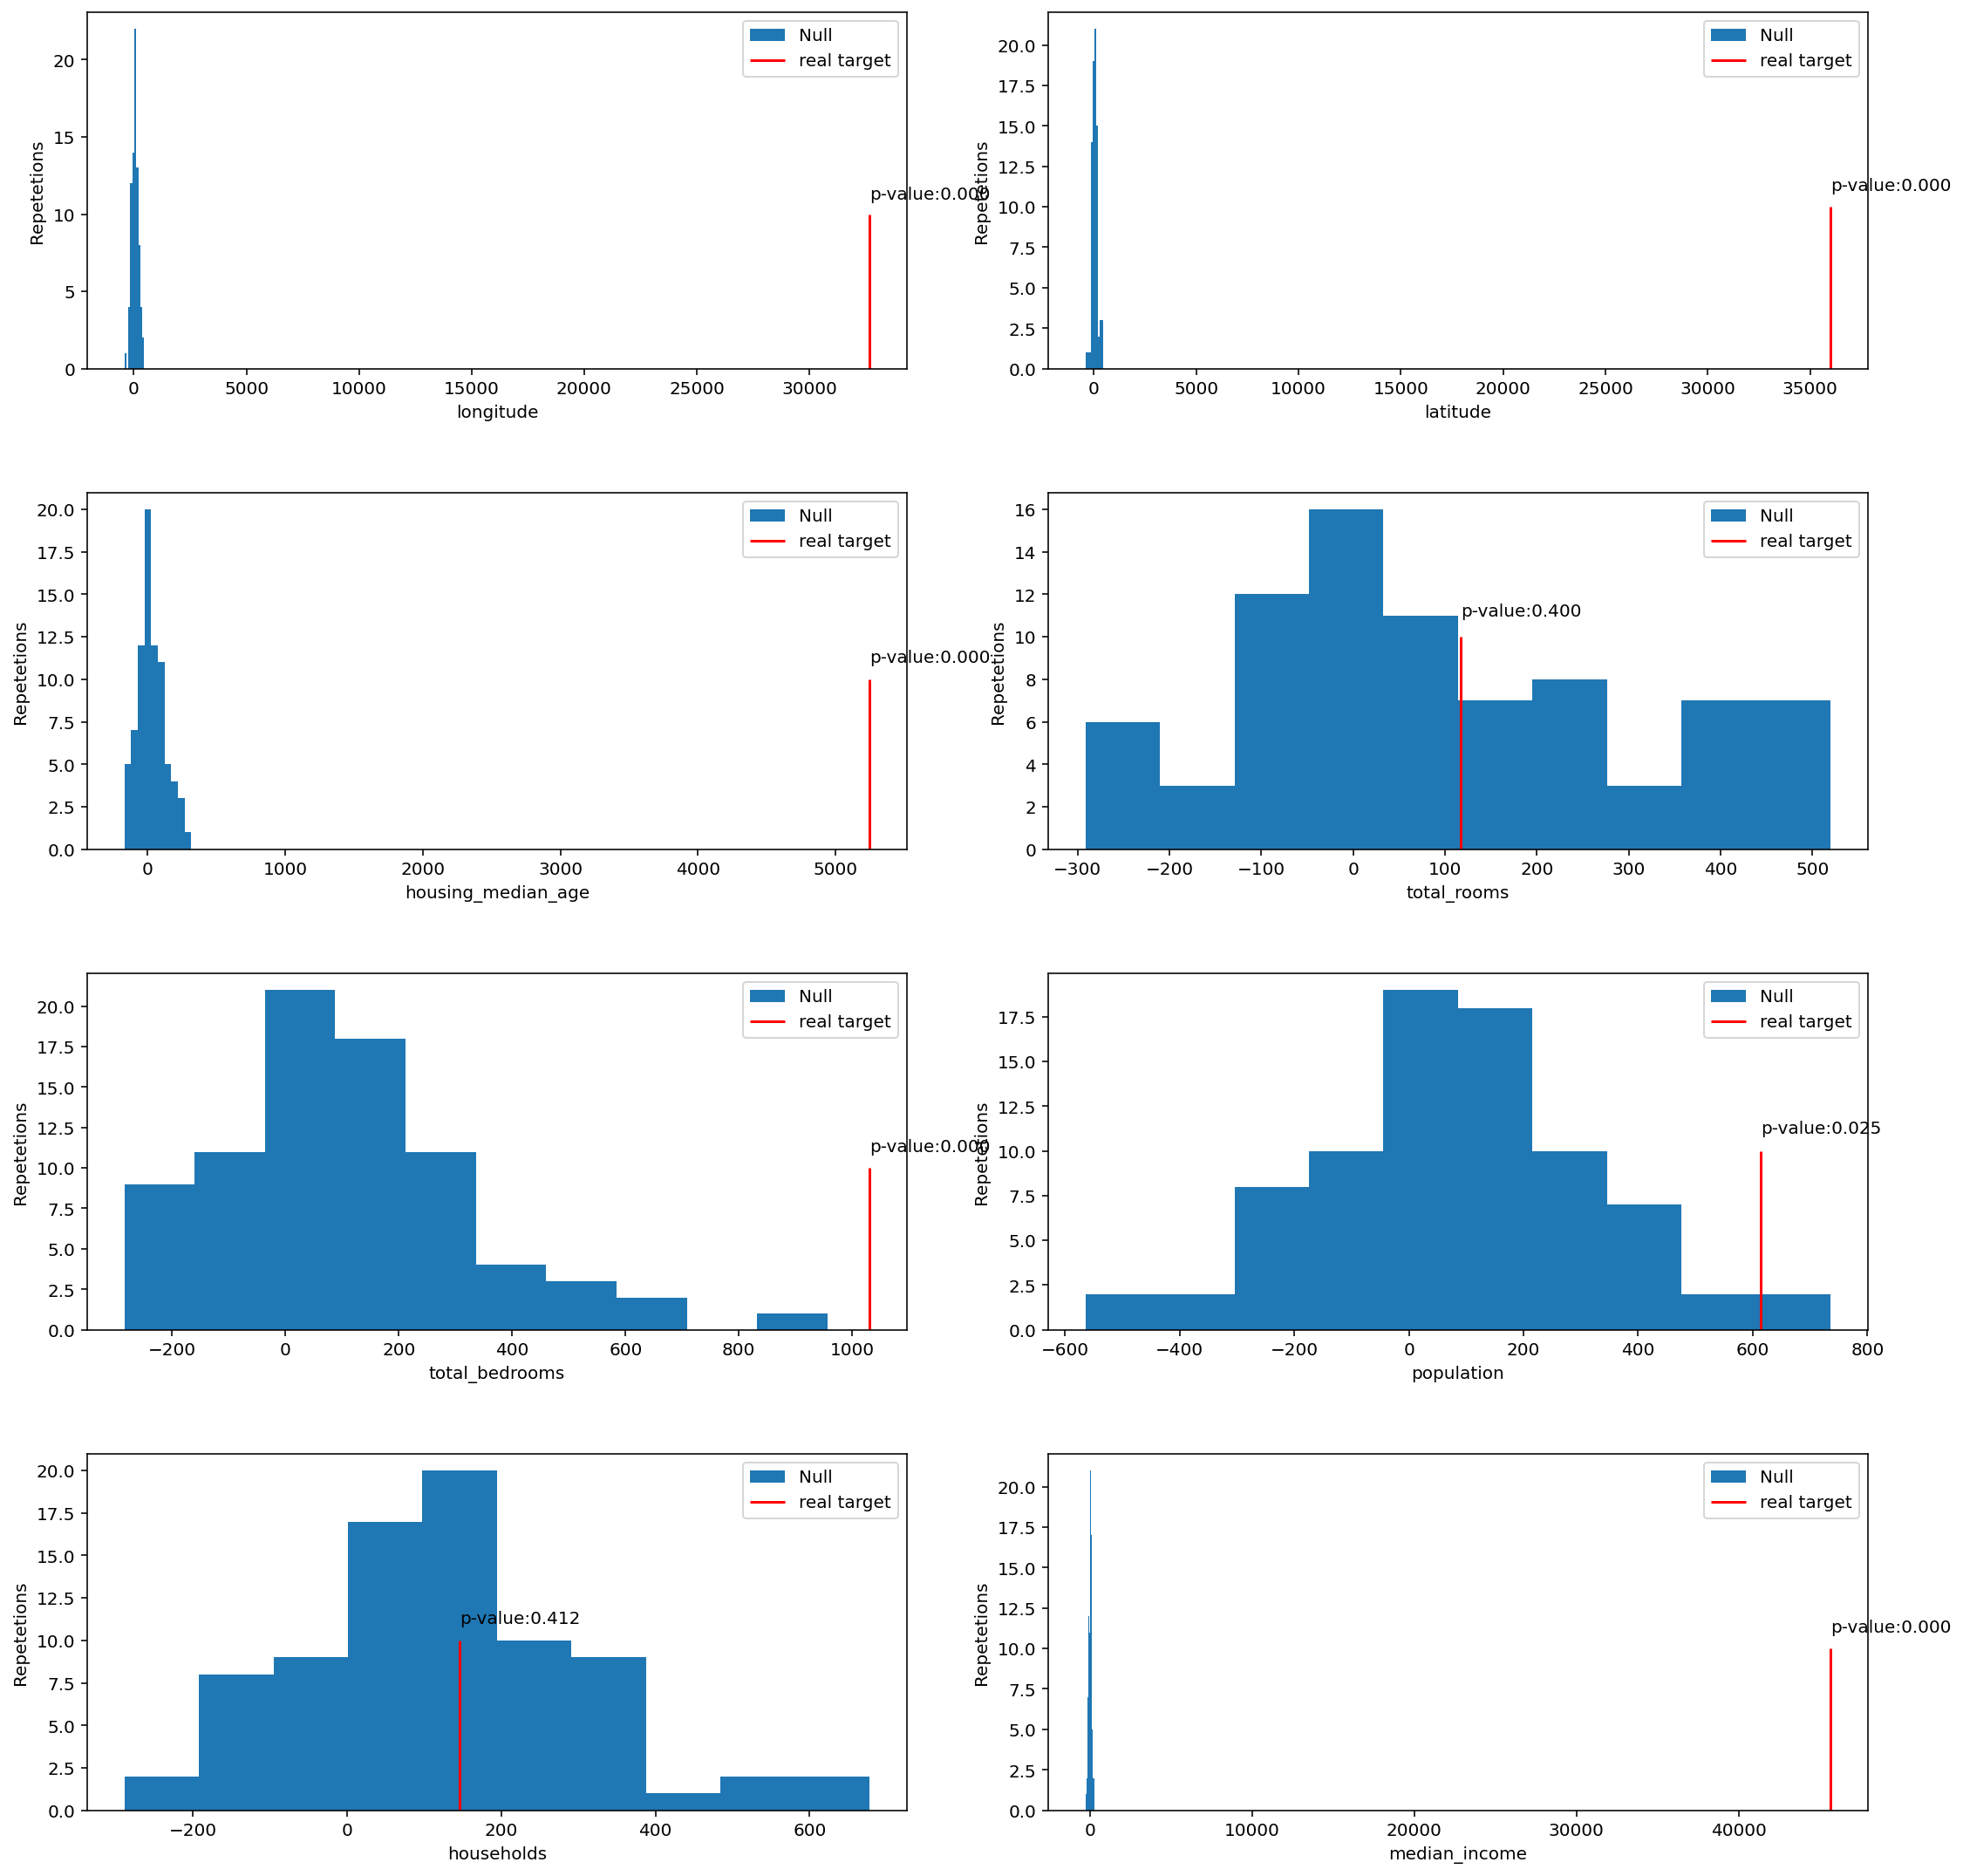

In [146]:
p_value_plot(housing,target = 'median_house_value')

As seen above longitude,latitude,housing_median_age, total bedrooms, population and median_income are significant features since their p-value is less than 0.05. Features such as total_rooms and households are not significant since their p-value is greater than 0.05 which means their feature importance is not significantly different from the null distribution. Hence the p-values gives another way to select significant features based on overlap of feature importance with Null distribution.

## 7. Conclusion
In conclusion we have discussed various feature importance strategies along with why we need feature importance to begin with. We have developed ways to judge if a feature is important or not based on relative and absolute terms based on these strategies. This gave us a method to rank features based on feature importance and various strategies to do so. We have also developed a strategy to compare various feature importance methodology and to select the top k features based on automatic feature selection for a given model. We also discussed the reliability of our feature importance values by gnerating the confidence interval for our feature importance values. Finally we discussed a way to get the p-value for each feaure importance by comparing with the null distribution of feature importance. 

Further advanced ways are available to develop feature selection and ranking our features. AutoML use some of these automated strategies to select features for automated feature selection and model development. Further otimizations are required here to make these strategies to work at scale in a ML pipeline. 